# CIFAR-10 model fine-tuning

Network structure:

*   AlexNet backbone network
*   Custom classification header

Building a fine-tuned model for AlexNet using PyTorch since Keras lacks a pre-trained model for AlexNet. Fine-tuning the backbone network, classification header, and classification header separately.

In [10]:
import torchvision.models as models 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import alexnet 
import matplotlib as mpl
import matplotlib.pyplot as plt

## Data preprocessing 

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


The model is divided into three parts:

*   features
*   avgpool
*   classifier

## Fine-tuning of AlexNet classification header

In [4]:
Alexnet_model = alexnet(pretrained=True)  

for parameters in Alexnet_model.features.parameters():
    parameters.requires_grad = False

Alexnet_model.classifier._modules['6'] = nn.Linear(4096, 10)

for parameters in Alexnet_model.classifier.parameters():
    parameters.requires_grad = True
if torch.cuda.is_available():
    Alexnet_model = Alexnet_model.to('cuda')

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [5]:
print('alexnet:')
print(Alexnet_model)

alexnet:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bia

In [6]:
params = [p for p in Alexnet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001) 
loss_fn = nn.CrossEntropyLoss().to('cuda')

In [7]:
def model_fit(epoch, model, trainloader, testloader):
    for x_train, y_train in trainloader:
        if torch.cuda.is_available():
            x_train, y_train = x_train.to('cuda'), y_train.to('cuda')
            
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct = 0 
        samples_num = 0 
        epoch_loss_sum = 0  
        with torch.no_grad():  
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_train).sum().item()
            samples_num += y_train.size(0)
            epoch_loss_sum += loss.item()
           
    
    epoch_loss = epoch_loss_sum / len(trainloader.dataset)
    epoch_acc = correct / samples_num
 
    
    test_correct = 0
    test_samples_num = 0
    test_loss_sum = 0
    model.eval()  
    with torch.no_grad():
        for x_test, y_test in testloader:
            if torch.cuda.is_available():
                x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
            y_pred = model(x_test)
            loss = loss_fn(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1)
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            test_loss_sum += loss.item()
 
    epoch_test_loss = test_loss_sum / len(testloader.dataset)
    epoch_test_acc = test_correct / test_samples_num
 
    print('epoch: ', epoch,
          'train loss： ', round(epoch_loss, 3),
          'train accuracy:', round(epoch_acc, 3),
          'test loss： ', round(epoch_test_loss, 3),
          'test accuracy:', round(epoch_test_acc, 3)
          )
 
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [8]:
epochs = 15
train_loss = []
train_acc = []
test_loss = []
test_acc = []
Alexnet_model = Alexnet_model.to('cuda')
for epoch in range(1, epochs + 1):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = model_fit(epoch,
                                                                  Alexnet_model,
                                                                  trainloader,
                                                                  testloader)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch:  1 train loss：  0.0 train accuracy: 0.69 test loss：  0.163 test accuracy: 0.776
epoch:  2 train loss：  0.0 train accuracy: 0.83 test loss：  0.147 test accuracy: 0.796
epoch:  3 train loss：  0.0 train accuracy: 0.86 test loss：  0.146 test accuracy: 0.799
epoch:  4 train loss：  0.0 train accuracy: 0.92 test loss：  0.163 test accuracy: 0.796
epoch:  5 train loss：  0.0 train accuracy: 0.94 test loss：  0.159 test accuracy: 0.81
epoch:  6 train loss：  0.0 train accuracy: 0.91 test loss：  0.177 test accuracy: 0.805
epoch:  7 train loss：  0.0 train accuracy: 0.9 test loss：  0.194 test accuracy: 0.812
epoch:  8 train loss：  0.0 train accuracy: 0.93 test loss：  0.246 test accuracy: 0.792
epoch:  9 train loss：  0.0 train accuracy: 0.92 test loss：  0.293 test accuracy: 0.788
epoch:  10 train loss：  0.0 train accuracy: 0.96 test loss：  0.238 test accuracy: 0.812
epoch:  11 train loss：  0.0 train accuracy: 0.99 test loss：  0.264 test accuracy: 0.817
epoch:  12 train loss：  0.0 train accuracy:

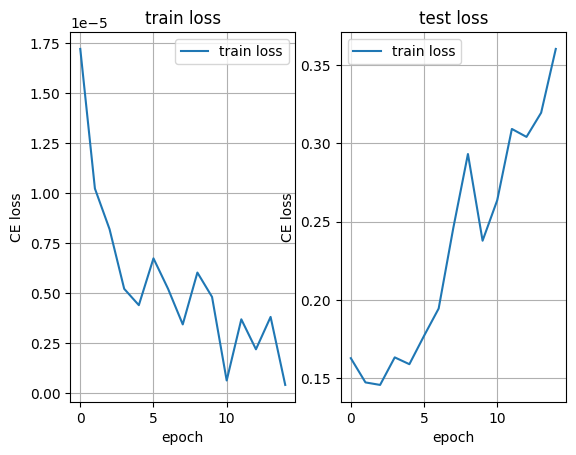

In [11]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss, label='train loss')
axs[1].legend()

The test loss indicates that after the second epoch, there was a noticeable increase, indicating the occurrence of overfitting. Although the test accuracy remained relatively constant.

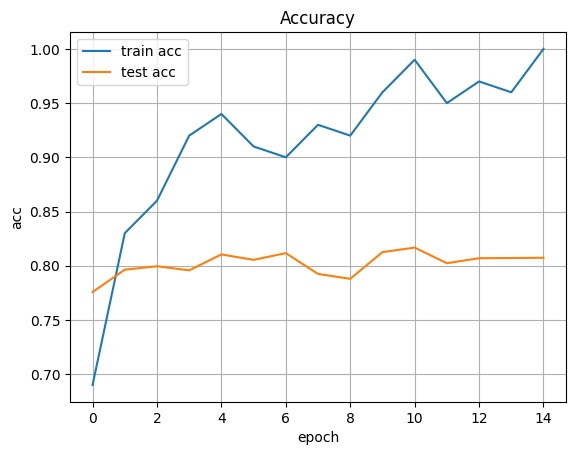

In [12]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

## Fine-tuning the backbone network and classification header

Building the network without freezing the feature layer

In [13]:
Alexnet_model_2 = alexnet(pretrained=True)  

Alexnet_model_2.classifier._modules['6'] = nn.Linear(4096, 10)

for parameters in Alexnet_model_2.classifier.parameters():
    parameters.requires_grad = True
if torch.cuda.is_available():
    Alexnet_model_2 = Alexnet_model_2.to('cuda')

In [14]:
params = [p for p in Alexnet_model_2.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params,lr=0.001) 
loss_fn = nn.CrossEntropyLoss().to('cuda') 

In [15]:
def model_fit(epoch, model, trainloader, testloader):
    for x_train, y_train in trainloader:
        if torch.cuda.is_available():
            x_train, y_train = x_train.to('cuda'), y_train.to('cuda')
            
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct = 0 
        samples_num = 0 
        epoch_loss_sum = 0 
        with torch.no_grad(): 
            y_pred = torch.argmax(y_pred, dim=1)
            correct += (y_pred == y_train).sum().item()
            samples_num += y_train.size(0)
            epoch_loss_sum += loss.item()
           
    epoch_loss = epoch_loss_sum / len(trainloader.dataset)
    epoch_acc = correct / samples_num
 
    test_correct = 0
    test_samples_num = 0
    test_loss_sum = 0
    model.eval()  
    with torch.no_grad():
        for x_test, y_test in testloader:
            if torch.cuda.is_available():
                x_test, y_test = x_test.to('cuda'), y_test.to('cuda')
            y_pred = model(x_test)
            loss = loss_fn(y_pred, y_test)
            y_pred = torch.argmax(y_pred, dim=1) 
            test_correct += (y_pred == y_test).sum().item()
            test_samples_num += y_test.size(0)
            test_loss_sum += loss.item()
 
    epoch_test_loss = test_loss_sum / len(testloader.dataset)
    epoch_test_acc = test_correct / test_samples_num
 
    print('epoch: ', epoch,
          'train loss： ', round(epoch_loss, 3),
          'train accuracy:', round(epoch_acc, 3),
          'test loss： ', round(epoch_test_loss, 3),
          'test accuracy:', round(epoch_test_acc, 3)
          )
 
    return epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc

In [16]:
epochs = 15
train_loss_2 = []
train_acc_2 = []
test_loss_2 = []
test_acc_2 = []
Alexnet_model_2 = Alexnet_model_2.to('cuda')
for epoch in range(1, epochs + 1):
    epoch_loss, epoch_acc, epoch_test_loss, epoch_test_acc = model_fit(epoch,
                                                                  Alexnet_model_2,
                                                                  trainloader,
                                                                  testloader)
    train_loss_2.append(epoch_loss)
    train_acc_2.append(epoch_acc)
    test_loss_2.append(epoch_test_loss)
    test_acc_2.append(epoch_test_acc)

epoch:  1 train loss：  0.0 train accuracy: 0.6 test loss：  0.244 test accuracy: 0.664
epoch:  2 train loss：  0.0 train accuracy: 0.77 test loss：  0.185 test accuracy: 0.747
epoch:  3 train loss：  0.0 train accuracy: 0.82 test loss：  0.172 test accuracy: 0.768
epoch:  4 train loss：  0.0 train accuracy: 0.87 test loss：  0.178 test accuracy: 0.765
epoch:  5 train loss：  0.0 train accuracy: 0.87 test loss：  0.186 test accuracy: 0.781
epoch:  6 train loss：  0.0 train accuracy: 0.83 test loss：  0.168 test accuracy: 0.793
epoch:  7 train loss：  0.0 train accuracy: 0.85 test loss：  0.167 test accuracy: 0.788
epoch:  8 train loss：  0.0 train accuracy: 0.9 test loss：  0.182 test accuracy: 0.802
epoch:  9 train loss：  0.0 train accuracy: 0.87 test loss：  0.201 test accuracy: 0.775
epoch:  10 train loss：  0.0 train accuracy: 0.92 test loss：  0.209 test accuracy: 0.788
epoch:  11 train loss：  0.0 train accuracy: 0.88 test loss：  0.203 test accuracy: 0.808
epoch:  12 train loss：  0.0 train accuracy:

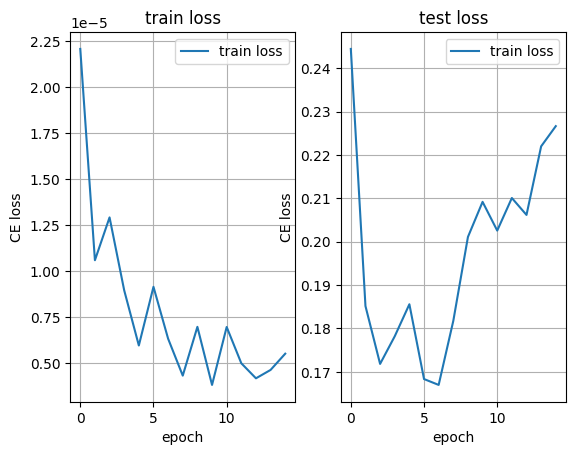

In [17]:
fig, axs = plt.subplots(1, 2)
axs[0].set_title('train loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].grid(True)
axs[0].plot(train_loss_2, label='train loss')
axs[0].legend()
axs[1].set_title('test loss')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('CE loss')
axs[1].grid(True)
axs[1].plot(test_loss_2, label='train loss')
axs[1].legend()

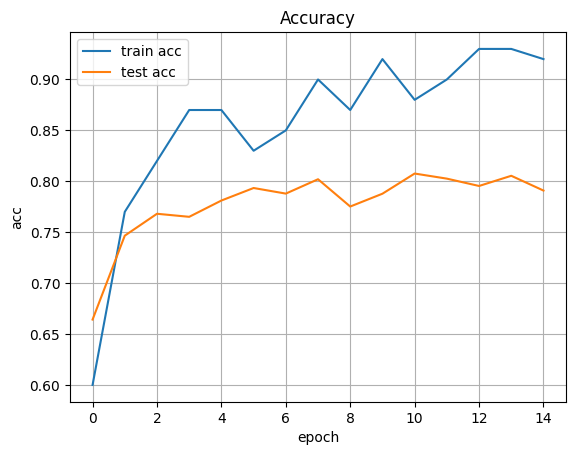

In [18]:
plt.figure(2)
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid(True)
plt.plot(train_acc_2, label='train acc')
plt.plot(test_acc_2, label='test acc')
plt.legend()

It is evident that the fine-tuned AlexNet model performs significantly better than the one we implemented in class.